In [1]:
import warnings
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Define Model Function

**Function to do three specific tasks**
1. Data Cleaning
     - Remove outliers for price
     - Change dat columns to date format
     - Drop rows with null values
     - Scale numerical values
     - One hot encode categorical values
2. Train Model
     - Train Random Forest Regressor model

3. Store Output
     - feature_importances
     - train_r2
     - test_r2
     - train_mse
     - test_mse
     - model
     - X_train
     - y_train
     - X_test
     - y_test

In [2]:
def RandomForestRegression(directory, param):
    # listings = pd.read_csv('./data/WashingtonDC/listings.csv')
    listings = pd.read_csv(directory)
    df = listings.copy()

    df['price_num'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    df['host_response_rate'] = df['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)
    df['host_response_rate'] = df['host_response_rate'].replace({np.nan:0})

    df['taken_30'] = 30-df['availability_30']
    df['taken_60'] = 60-df['availability_60']

    df['sales_30'] = df['taken_30'] * df['price_num']
    df['sales_60'] = df['taken_60'] * df['price_num']

    # Column types
    df['host_since'] = pd.to_datetime(df['host_since'])
    df['first_review'] = pd.to_datetime(df['first_review'])
    df['last_review'] = pd.to_datetime(df['last_review'])

    specific_date = pd.to_datetime('2024-04-04')
    df['host_days_since'] = (specific_date - df['host_since']).dt.days

    df[['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','instant_bookable']] = df[['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','instant_bookable']].replace({'t': 1, 'f': 0})
    df[['host_response_time']] = df[['host_response_time']].replace({np.nan: 0, 'within a few hours': 3, 'within an hour': 4, 'within a day': 2, 'a few days or more': 1})

    # df['host_desc_len'] = [0 if pd.isna(i) else len(i) for i in df['host_about']]

    # Calculate Q1 (25th percentile of the data) for the 'price' column
    Q1 = df['price_num'].quantile(0.25)

    # Calculate Q3 (75th percentile of the data) for the 'price' column
    Q3 = df['price_num'].quantile(0.75)

    # Calculate the IQR by subtracting Q1 from Q3
    IQR = Q3 - Q1

    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    df_filtered = df[(df['price_num'] <= upper_bound)]

    top_10 = df_filtered['neighbourhood_cleansed'].value_counts().keys()
    # top_10 = df_filtered['neighbourhood_cleansed'].value_counts().head(10).keys()
    top10_df = df_filtered[df_filtered['neighbourhood_cleansed'].isin(top_10)]
    temp = top10_df[top10_df['neighbourhood_cleansed'].isin(top_10)]
    temp = temp[temp['property_type'].str.contains('entire', case=False, na=False)]

    df_num = temp[['price_num','host_response_rate','instant_bookable','host_listings_count','host_total_listings_count','host_response_time','host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','latitude','longitude','accommodates','beds','minimum_nights','maximum_nights','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month','host_days_since','neighbourhood_cleansed']]

    df_num_drop = df_num.dropna()

    # 1. Separate the 'neighbourhood_cleansed' column from the rest of the DataFrame
    numerical = ['price_num','neighbourhood_cleansed','host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','host_response_time']

    numerical_features = df_num_drop.drop(numerical, axis=1)
    non_numerical_feature = df_num_drop[numerical]

    # 2. Scale only the numerical columns
    scaler = StandardScaler()
    numerical_features_scaled = scaler.fit_transform(numerical_features)
    df_numerical_scaled = pd.DataFrame(numerical_features_scaled, columns=numerical_features.columns)

    # 3. Concatenate the scaled numerical columns and the 'non-numerical' columns
    df_standardized = pd.concat([df_numerical_scaled, non_numerical_feature.reset_index(drop=True)], axis=1)
    df_standardized = pd.get_dummies(df_standardized, columns=['neighbourhood_cleansed'])
    

    # Split data into training and testing sets
    X = df_standardized.drop(columns=['price_num'])
    y = df_standardized['price_num']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the model
    model = RandomForestRegressor(**param, random_state=42)
    model.fit(X_train, y_train)

    # Print feature importances
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    # print("Top 10 Feature Importances:\n", feature_importances[:10])

    # Make predictions on the test set
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)

    # Calculate and print the metrics
    test_mse = mean_squared_error(y_test, test_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)

    test_r2 = r2_score(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    return feature_importances, train_r2, test_r2, train_mse, test_mse, model, X_train, y_train, X_test, y_test

In [3]:
directory_path = './data/'
entries = os.listdir('./data/')

params = {
    'n_estimators': 200,
    'max_depth': 11,
    'min_samples_split': 5,
    'min_samples_leaf': 2
}

results = {}

# Loop over each entry and check if it is a directory
for entry in entries:
    full_path = os.path.join(directory_path, entry)
    full_path = full_path + '/data_cleaned.csv'

    feature, train_r2, test_r2, train_mse, test_mse, model, X_train, y_train, X_test, y_test = RandomForestRegression(full_path,params)

    results[entry] = {}
    results[entry]['feature_importance'] = feature
    results[entry]['train_r2'] = train_r2
    results[entry]['test_r2'] = test_r2
    results[entry]['train_mse'] = train_mse
    results[entry]['test_mse'] = test_mse
    results[entry]['model'] = model
    results[entry]['X_train'] = X_train
    results[entry]['y_train'] = y_train
    results[entry]['X_test'] = X_test
    results[entry]['y_test'] = y_test

    print(f"{entry} complete")


Athens complete
Austin complete
Bangkok complete
Barcelona complete
Boston complete
Hawaii complete
LosAngeles complete
MexicoCity complete
NewYork complete
Paris complete
Rome complete
Seattle complete
Singapore complete
WashingtonDC complete


# Print Results

In [4]:
test_mse = [(i,np.sqrt(results[i]['test_mse'])) for i in results]
test_mse

[('Athens', 25.00423284005543),
 ('Austin', 64.52210290955674),
 ('Bangkok', 132.70311724482357),
 ('Barcelona', 33.114940780075734),
 ('Boston', 59.744446725224975),
 ('Hawaii', 86.94059773983115),
 ('LosAngeles', 62.527713990906406),
 ('MexicoCity', 142.23128356541875),
 ('NewYork', 62.31248584793697),
 ('Paris', 51.0240683608615),
 ('Rome', 41.15223530652953),
 ('Seattle', 45.71573533611363),
 ('Singapore', 83.09709029661124),
 ('WashingtonDC', 45.523118749781524)]

In [5]:
train_mse = [(i,np.sqrt(results[i]['train_mse'])) for i in results]
train_mse

[('Athens', 16.030772875447376),
 ('Austin', 40.956499870468534),
 ('Bangkok', 70.56512316916931),
 ('Barcelona', 21.744164240614428),
 ('Boston', 29.62480671233815),
 ('Hawaii', 68.92281206700633),
 ('LosAngeles', 48.53511552562788),
 ('MexicoCity', 97.49669585246227),
 ('NewYork', 46.52881504858571),
 ('Paris', 43.613816744398456),
 ('Rome', 30.498215326542876),
 ('Seattle', 27.12795116034988),
 ('Singapore', 43.32279370325034),
 ('WashingtonDC', 26.005219297710894)]

In [6]:
test_r2 = [(i,results[i]['test_r2']) for i in results]
test_r2

[('Athens', 0.43618478040929065),
 ('Austin', 0.5070771301835859),
 ('Bangkok', 0.312475220030484),
 ('Barcelona', 0.49551286889437196),
 ('Boston', 0.4793169680213235),
 ('Hawaii', 0.5853540052121047),
 ('LosAngeles', 0.5117297719342153),
 ('MexicoCity', 0.3385634444334662),
 ('NewYork', 0.42325266679051954),
 ('Paris', 0.48705859833970777),
 ('Rome', 0.41696520539802007),
 ('Seattle', 0.44506748139753605),
 ('Singapore', 0.6008928541560609),
 ('WashingtonDC', 0.42145299321209384)]

In [7]:
train_r2 = [(i,results[i]['train_r2']) for i in results]
train_r2

[('Athens', 0.7626471910752671),
 ('Austin', 0.7998601449459566),
 ('Bangkok', 0.7912012910830923),
 ('Barcelona', 0.7888126641208983),
 ('Boston', 0.8524251734391429),
 ('Hawaii', 0.7304414503090939),
 ('LosAngeles', 0.6953007934492696),
 ('MexicoCity', 0.7043433491447175),
 ('NewYork', 0.699991461157585),
 ('Paris', 0.6220713123821484),
 ('Rome', 0.6790923718949307),
 ('Seattle', 0.8091109622208366),
 ('Singapore', 0.8920333643331394),
 ('WashingtonDC', 0.8082954411082812)]

# Graph Results

## MSE

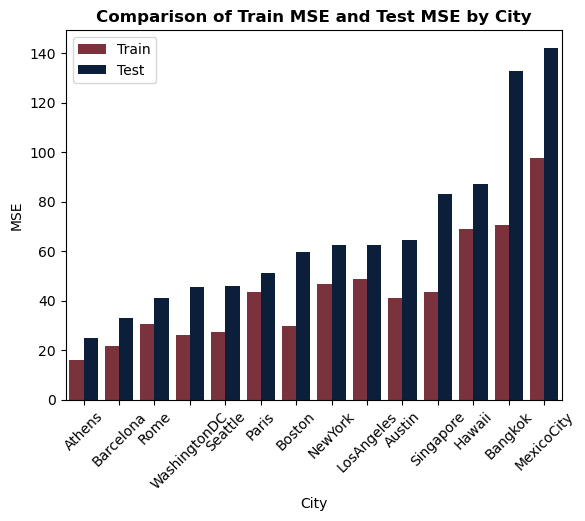

In [8]:
test_mse = [np.sqrt(results[i]['test_mse']) for i in results]
train_mse = [np.sqrt(results[i]['train_mse']) for i in results]
keys = [i for i in results]


df = pd.DataFrame(list(zip(keys,train_mse,test_mse)),columns=['City','Train','Test'])

sorted_cities = df.sort_values('Test')['City'].tolist()

df_long = df.melt(id_vars='City', var_name='Type', value_name='MSE')
# Create the barplot with dodged bars
palette = sns.color_palette("pastel")
custom_palette = ['#862633','#041e42'] 

sns.barplot(x='City', y='MSE', hue='Type', data=df_long, dodge=True, order=sorted_cities, palette = custom_palette)

# Customize the plot
plt.title('Comparison of Train MSE and Test MSE by City',  fontweight = 'bold')
plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.xlabel('City')
plt.ylabel('MSE')
plt.legend()
plt.savefig('./MSE.png', dpi=300, bbox_inches='tight', transparent=True)  # Save as PNG with high resolution


plt.show()

## R squared

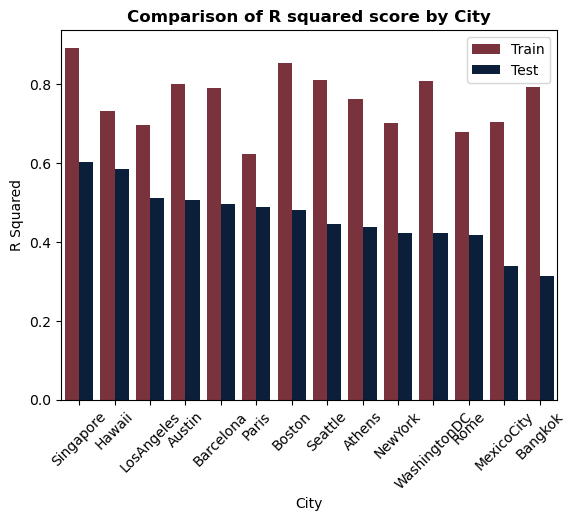

In [9]:
test_r2 = [(results[i]['test_r2']) for i in results]
train_r2 = [(results[i]['train_r2']) for i in results]
keys = [i for i in results]

df = pd.DataFrame(list(zip(keys,train_r2,test_r2)),columns=['City','Train','Test'])
sorted_cities = df.sort_values('Test', ascending=False)['City'].tolist()
df_long = df.melt(id_vars='City', var_name='Type', value_name='R Squared')
# Create the barplot with dodged bars
palette = sns.color_palette("pastel")
custom_palette = ['#862633','#041e42'] 
sns.barplot(x='City', y='R Squared', hue='Type', data=df_long, dodge=True, order=sorted_cities,palette=custom_palette)

# Customize the plot
plt.title('Comparison of R squared score by City', fontweight = 'bold')
plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.xlabel('City')
plt.ylabel('R Squared')
plt.legend()
plt.savefig('./R2.png', dpi=300, bbox_inches='tight', transparent=True)  # Save as PNG with high resolution

plt.show()

# Sanity Check
Compare histograms for output results and actual values to ensure distributions are similar

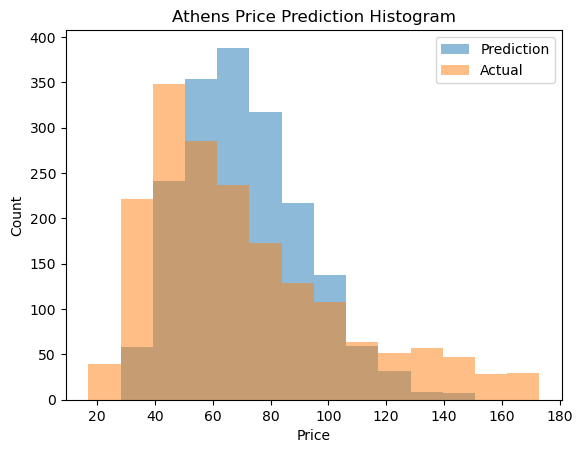

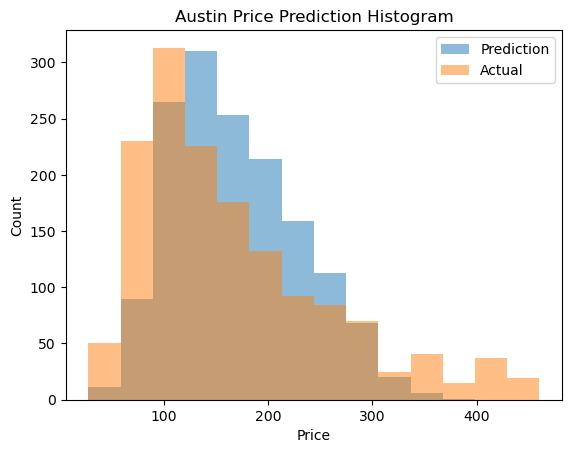

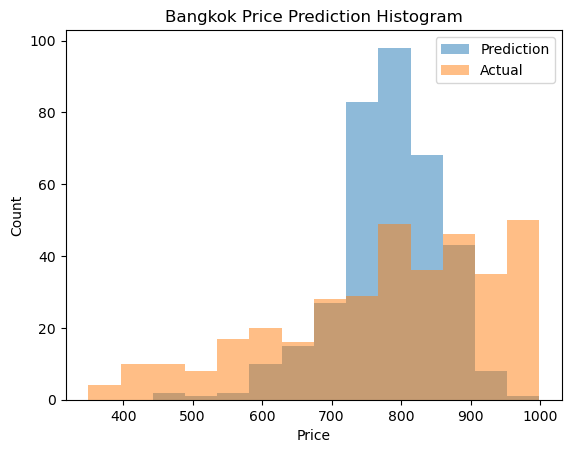

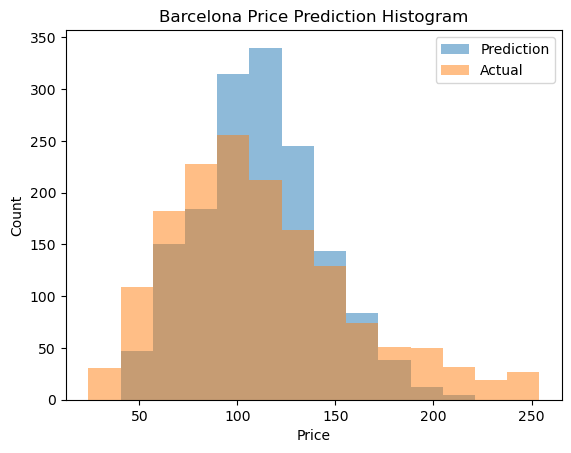

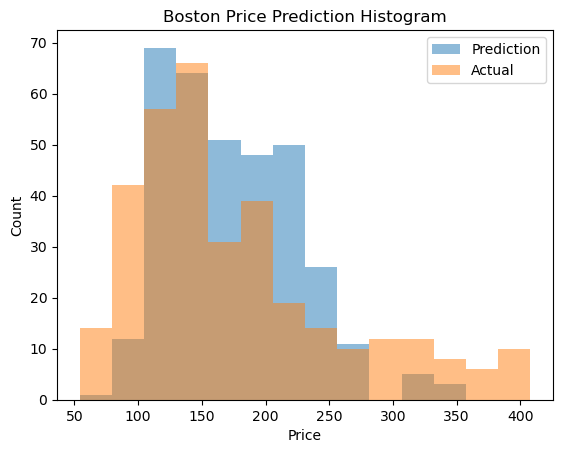

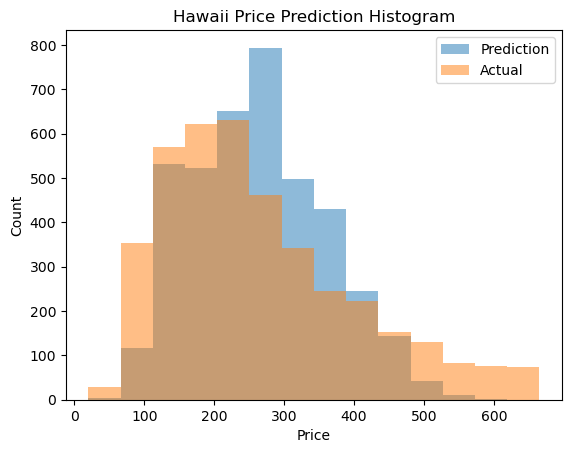

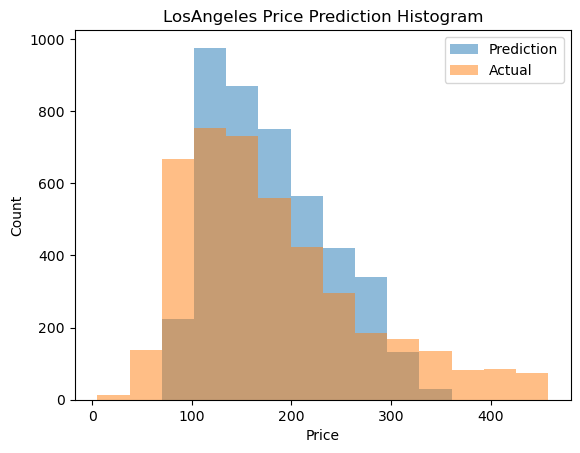

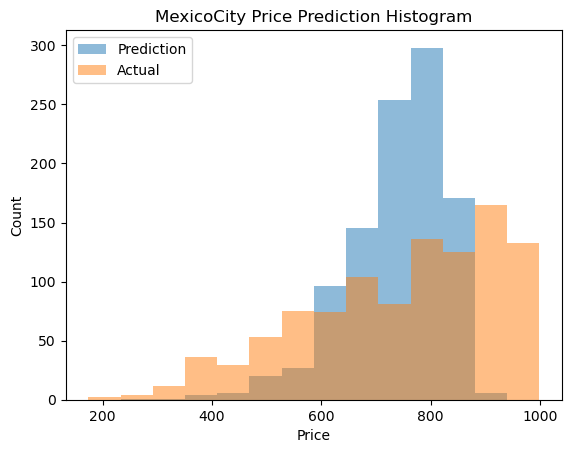

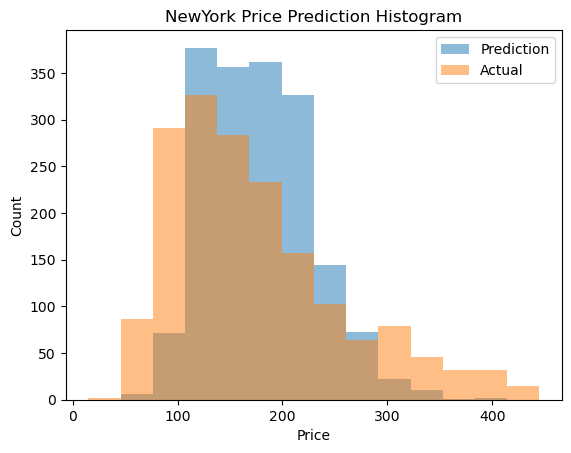

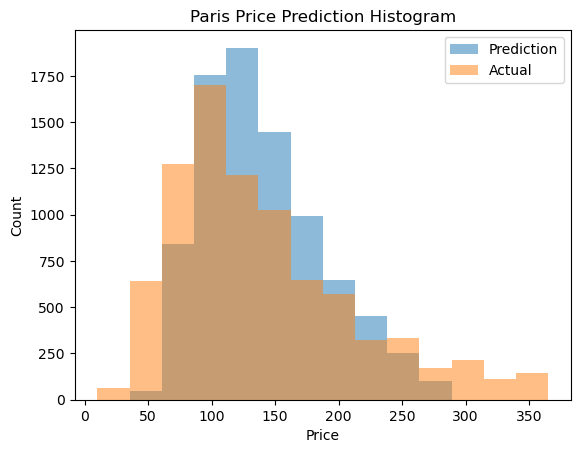

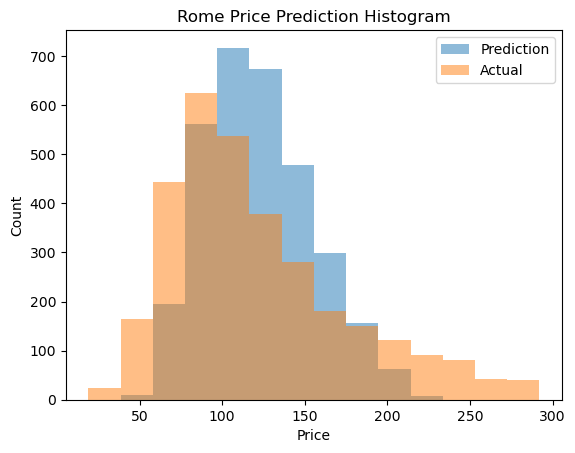

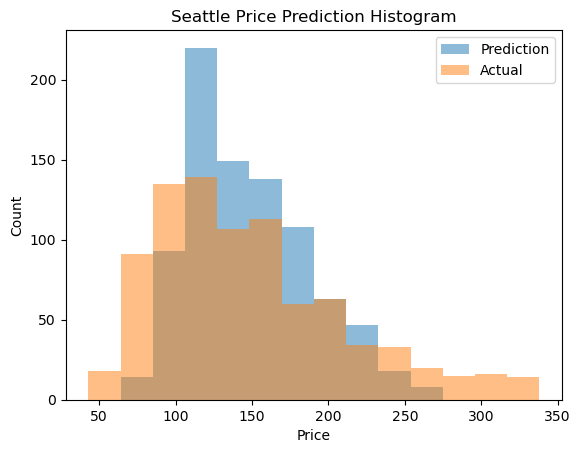

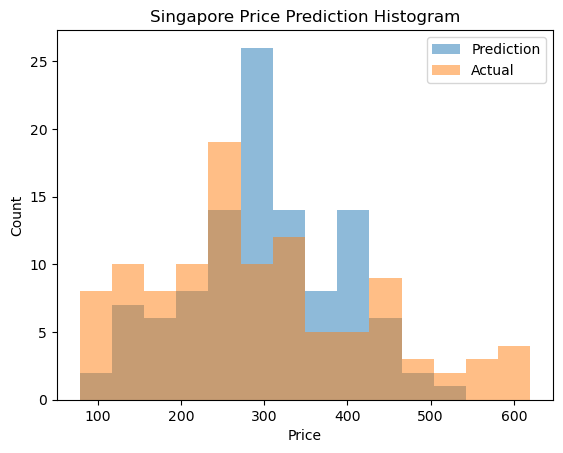

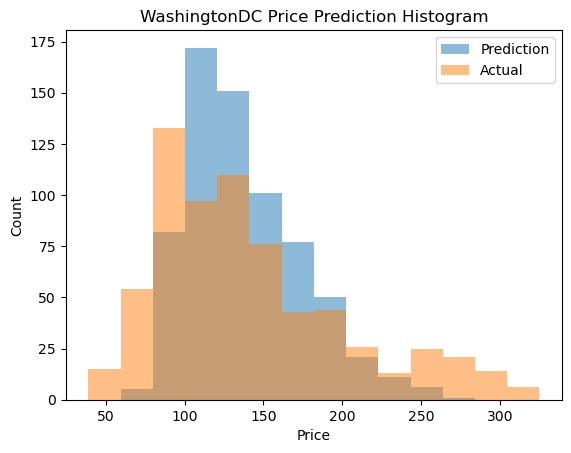

In [10]:
for i in results:
    model = results[i]['model']
    X_test = results[i]['X_test']
    y_test = results[i]['y_test']

    # Make predictions on the test set
    test_predictions = model.predict(X_test)

    # Determine the common range for the histograms
    bin_min = min(min(test_predictions), min(y_test))  # Lowest value between both
    bin_max = max(max(test_predictions), max(y_test))  # Highest value between both

    # Define the number of bins or the bin width you desire
    number_of_bins = 15  # For example, 30 bins
    # Or

    # If using number of bins directly:
    bins = np.linspace(bin_min, bin_max, number_of_bins)

    plt.title(f'{i} Price Prediction Histogram')
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.hist(test_predictions, alpha = 0.5, bins = bins, label = 'Prediction')
    plt.hist(y_test, alpha = 0.5, bins = bins, label = 'Actual')
    plt.legend()
    # plt.savefig(f'./{city}_histogram.png')
    plt.show()